Loading the Required Libraries and Modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle

import re
import string
import nltk
from nltk.corpus import stopwords

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



from PIL import Image

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to /home/chi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading the Data and Performing Basic Data Checks

In [3]:
df = pd.read_csv('Apple-Twitter-Sentiment-DFE.csv')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


Selecting required columns and rows

In [4]:
data=pd.concat([df.text, df._golden],axis=1)
data.dropna(axis=0,inplace=True)  # For drop nan values. It makes confuse for our model.
data.tail()

,text,_golden
3881,(Via FC) Apple Is Warming Up To Social Media -...,True
3882,RT @MMLXIV: there is no avocado emoji may I as...,True
3883,@marcbulandr I could not agree more. Between @...,True
3884,My iPhone 5's photos are no longer downloading...,True
3885,RT @SwiftKey: We're so excited to be named to ...,True


([<matplotlib.patches.Wedge at 0x7f3ca9833110>,
 [Text(-0.6558421247049934, -0.9446539617566002, 'False'),
  Text(0.6273272708676837, 0.9035820356922243, 'True')],
 [Text(-0.3706933748332571, -0.5339348479493826, '97.3%'),
  Text(0.34217851138237293, 0.49286292855939495, '2.7%')])

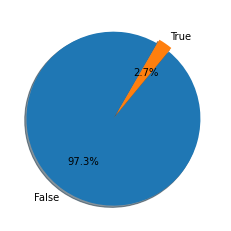

In [5]:
x = data['_golden'].value_counts()
plt.pie(x, labels=["False", "True"], autopct='%1.1f%%',
       shadow=True, explode=(0.05, 0), startangle=60)

In [6]:
data['category_id'] = data['_golden'].factorize()[0]

data.head()

,text,_golden,category_id
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,True,0
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,True,0
2,My cat only chews @apple cords. Such an #Apple...,True,0
3,I agree with @jimcramer that the #IndividualIn...,True,0
4,Nobody expects the Spanish Inquisition #AAPL,False,1


In [7]:
true = data[data['category_id'] == 0]['text']
true.values[1]

'RT @JPDesloges: Why AAPL Stock Had a Mini-Flash Crash Today $AAPL #aapl\nhttp://t.co/hGFcjYa0E9'

In [8]:
false = data[data['category_id'] == 1]['text']
false.values[1]

"#AAPL:This Presentation Shows What Makes The World's Biggest Tech Companies ...http://t.co/qlH9PqSoSd"

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

data['text'] = data['text'].apply(lambda x: clean_text(x))

data['text'].head()

0                 aaplthe  best steve jobs emails ever
1    rt jpdesloges why aapl stock had a miniflash c...
2      my cat only chews apple cords such an applesnob
3    i agree with jimcramer that the individualinve...
4          nobody expects the spanish inquisition aapl
Name: text, dtype: object

Creating the Training and Test Datasets

In [10]:
X = data['text']
target = data['_golden']

Converting Text to Word Frequency Vectors with CountVectorizer 

In [11]:
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(data['text'].values.astype('U'))

In [12]:
from sklearn.model_selection import train_test_split

target = data['category_id']

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.30, random_state = 100)

Create and Fit the Classifier.

In [14]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [15]:
prediction=nb.predict(X_test)
print(prediction[: 10])

[1 1 1 1 1 1 1 1 1 1]


Create a confusion matrix and classification report

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, prediction))

[[   0   38]
 [  11 1117]]


In [17]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.97      0.99      0.98      1128

    accuracy                           0.96      1166
   macro avg       0.48      0.50      0.49      1166
weighted avg       0.94      0.96      0.95      1166



Using XGBoost algorithm to optimize the result

In [18]:
import xgboost as xgb
from xgboost import XGBClassifier

In [19]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
y_pred = classifier.predict(X_test)

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [22]:
cm

array([[   0,   38],
       [   1, 1127]])

Building Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [24]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 100)

classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=100)

In [28]:
predRF = classifier.predict(X_test) 
print(predRF[:10])

# Calculate the accuracy score
accuracy_RF = metrics.accuracy_score(y_test, predRF)
print(accuracy_RF)

Conf_metrics_RF = metrics.confusion_matrix(y_test, predRF, labels=[1, 0])
print(Conf_metrics_RF)

[1 1 1 1 1 1 1 1 1 1]
0.9656946826758147
[[1126    2]
 [  38    0]]
